# Comparison of HPD complaints for two zip codes, one with high value of autocorrelation and other with a low value

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
import statsmodels.api as sma
import patsy
import folium
from folium.plugins import HeatMap
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest
import csv
import geopandas as gpd
from statsmodels.graphics.api import abline_plot
%matplotlib inline

### Reading 311 data after 2014, for zip 10017 (low autocorrelation) and 10040 (high autocorrelation)

In [2]:
data = pd.read_csv('311After2014.csv')

In [3]:
data10017 = data[(data['Incident Zip'] == 10017)]
data10040 = data[data['Incident Zip'] == 10040]

In [4]:
data10017.sort_values(by='Cdate', inplace=True)
y = pd.to_datetime(data10017['Cdate'].values)
data10017['month'] = y.strftime("%y-%m")
#data10012['year']  = y.strftime("%y")
#data10012.head()

data10040.sort_values(by='Cdate', inplace=True)
y = pd.to_datetime(data10040['Cdate'].values)
data10040['month'] = y.strftime("%y-%m")

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [12]:
data10017HPD = data10017[(data10017.Agency == 'HPD')]
data10017HPD = data10017HPD.groupby(by='month').count()
data10017HPD['month'] = data10017HPD.index
data10017HPD.reset_index(drop=True, inplace=True)
data10017HPD.head()

data10040HPD = data10040[(data10040.Agency == 'HPD')]
data10040HPD = data10040HPD.groupby(by='month').count()
data10040HPD['month'] = data10040HPD.index
data10040HPD.reset_index(drop=True, inplace=True)
data10040HPD.head()

,Unnamed: 0,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Incident Zip,Status,Resolution Action Updated Date,Borough,Latitude,Longitude,Cdate,month
0,292,292,292,292,292,292,292,292,292,292,292,292,292,14-06
1,509,509,509,509,509,509,509,509,509,509,509,509,509,14-07
2,374,374,374,374,374,374,374,374,374,374,374,374,374,14-08
3,284,284,284,284,284,284,284,284,284,284,284,284,284,14-09
4,683,683,683,683,683,683,683,683,683,683,683,683,683,14-10


Text(0.5,1,'Comparison of two zips')

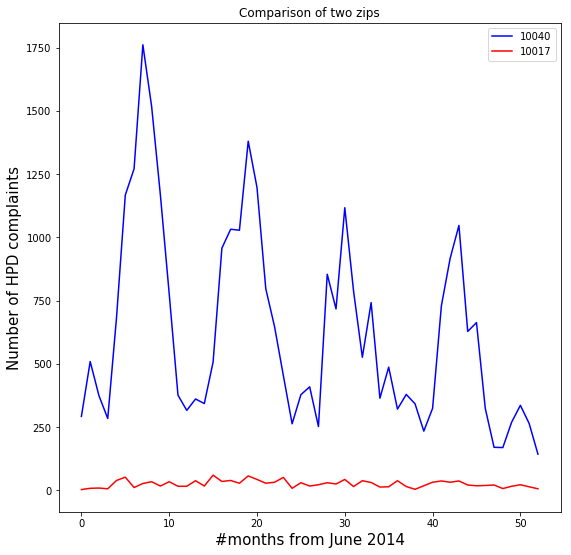

In [13]:
plt.figure(figsize=(9,9))
plt.plot(data10040HPD.index, data10040HPD['Unique Key'], color='blue', label='10040')
plt.plot(data10017HPD.index, data10017HPD['Unique Key'], color='red', label='10017')
plt.legend()
plt.ylabel('Number of HPD complaints', fontsize=15)
plt.xlabel('#months from June 2014', fontsize=15)
plt.title('Comparison of two zips')

Text(0.5,1,'Partial Autocorrelation 10040')

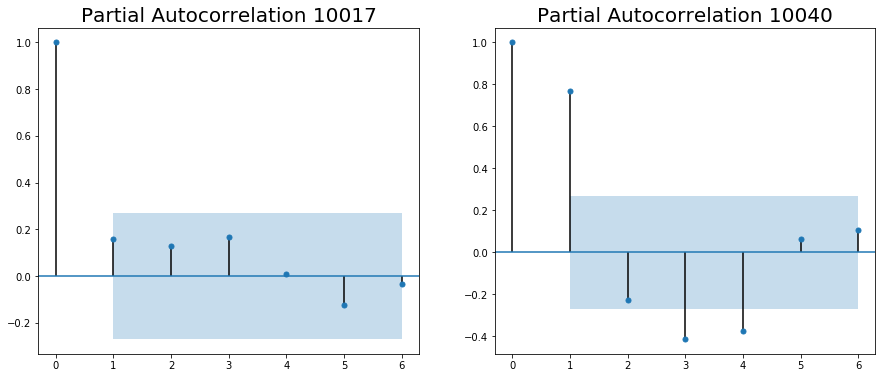

In [17]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
sma.graphics.tsa.plot_pacf(data10017HPD['Unique Key'].squeeze(), lags=6, ax=ax1)
plt.title(r'Partial Autocorrelation 10017', fontsize=20)

ax2 = fig.add_subplot(122)
sma.graphics.tsa.plot_pacf(data10040HPD['Unique Key'].squeeze(), lags=6, ax=ax2)
plt.title(r'Partial Autocorrelation 10040', fontsize=20)

## Some analyses on time series of the two zips

In [34]:
data10040HPD_rmean = data10040HPD['Unique Key'].rolling(2).mean()
data10017HPD_rmean = data10017HPD['Unique Key'].rolling(2).mean()
data10040HPD_rstd = data10040HPD['Unique Key'].rolling(2).std()
data10017HPD_rstd = data10017HPD['Unique Key'].rolling(2).std()

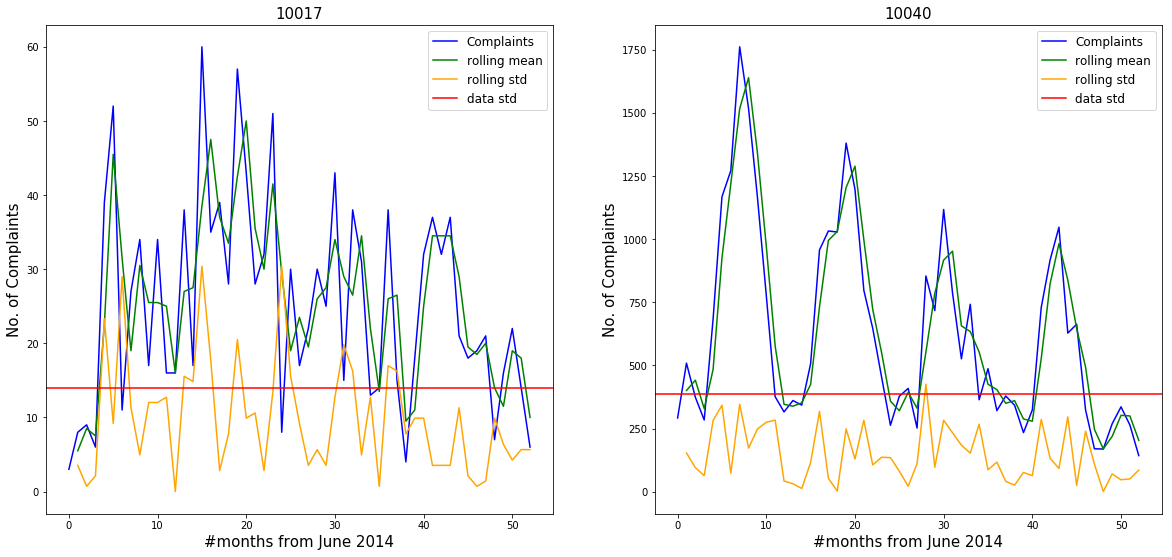

In [63]:
fig = plt.figure(figsize=(20,9))

ax1 = fig.add_subplot(121)
ax1.plot(data10017HPD.index, data10017HPD['Unique Key'], color='blue', label='Complaints')
ax1.plot(data10017HPD_rmean, label='rolling mean', color='green')
plt.plot(data10017HPD_rstd, label='rolling std', color='orange')
plt.title('10017', fontsize=15)
plt.xlabel('#months from June 2014', fontsize=15)
plt.ylabel('No. of Complaints', fontsize=15)
plt.axhline(data10017HPD['Unique Key'].std(), color='red', label='data std')
plt.legend(fontsize=12)

ax2 = fig.add_subplot(122)
ax2.plot(data10040HPD.index, data10040HPD['Unique Key'], color='blue', label='Complaints')
ax2.plot(data10040HPD_rmean, label='rolling mean', color='green')
ax2.plot(data10040HPD_rstd, label='rolling std', color='orange')
plt.title('10040', fontsize=15)
plt.xlabel('#months from June 2014', fontsize=15)
plt.ylabel('No. of Complaints', fontsize=15)
plt.axhline(data10040HPD['Unique Key'].std(), color='red', label='data std')
plt.legend(fontsize=12)

### Creating ARMA model for predictive analysis

In [57]:
arma_mod100 = sm.tsa.ARMA(data10017HPD[["Unique Key"]], (2,0)).fit()
print (sm.stats.durbin_watson(arma_mod100.resid.values))

arma_mod100.summary()

1.9868350998168798


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Unique Key   No. Observations:                   53
Model:                     ARMA(2, 0)   Log Likelihood                -213.392
Method:                       css-mle   S.D. of innovations             13.553
Date:                Sat, 01 Dec 2018   AIC                            434.784
Time:                        13:38:09   BIC                            442.665
Sample:                             0   HQIC                           437.814
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               24.9050      2.647      9.410      0.000      19.718      30.092
ar.L1.Unique Key     0.1508      0.139      1.083      0.284      -0.122       0.424
ar.L2.Unique Key     0.1463      0.142      1.031      0.307      -0.132       0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1495           +0.0000j            2.1495            0.0000
AR.2           -3.1804           +0.0000j            3.1804            0.5000
-----------------------------------------------------------------------------
"""

In [58]:
arma_mod101 = sm.tsa.ARMA(data10040HPD[["Unique Key"]], (2,0)).fit()
print (sm.stats.durbin_watson(arma_mod100.resid.values))

arma_mod101.summary()

1.9868350998168798


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Unique Key   No. Observations:                   53
Model:                     ARMA(2, 0)   Log Likelihood                -365.252
Method:                       css-mle   S.D. of innovations            235.763
Date:                Sat, 01 Dec 2018   AIC                            738.505
Time:                        13:38:16   BIC                            746.386
Sample:                             0   HQIC                           741.536
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              598.1196    115.149      5.194      0.000     372.432     823.808
ar.L1.Unique Key     0.9580      0.134      7.173      0.000       0.696       1.220
ar.L2.Unique Key    -0.2327      0.134     -1.736      0.089      -0.496       0.030
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0583           -0.2458j            2.0729           -0.0189
AR.2            2.0583           +0.2458j            2.0729            0.0189
-----------------------------------------------------------------------------
"""

In [59]:
pred100 = arma_mod100.predict(1,52)
pred101 = arma_mod101.predict(1,52)

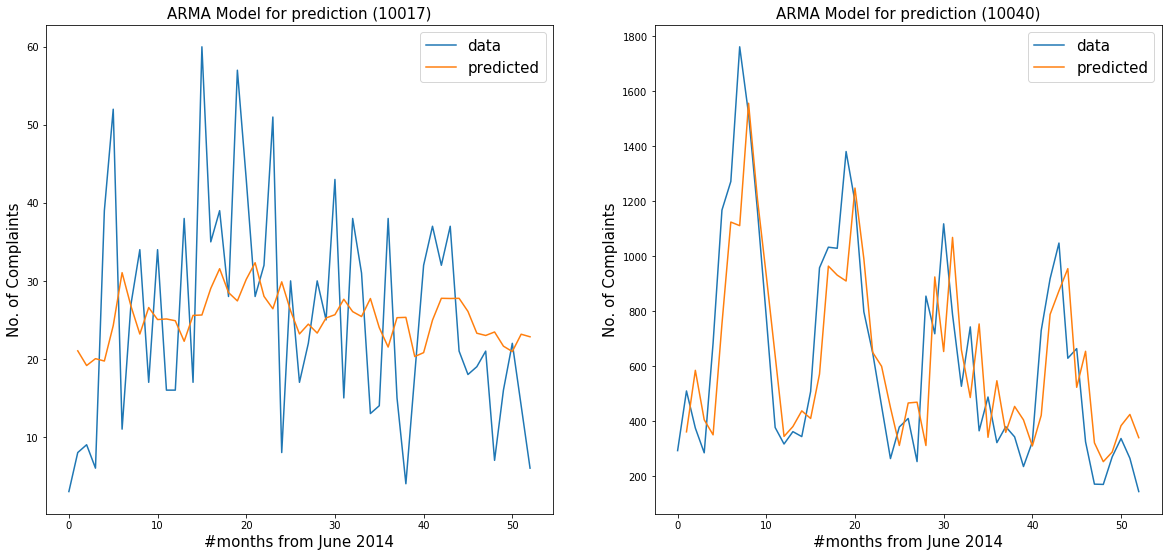

In [64]:
fig = plt.figure(figsize=(20,9))

ax1 = fig.add_subplot(121)
ax1.plot(data10017HPD.index, data10017HPD['Unique Key'], label='data')
ax1.plot(pred100, label='predicted')
plt.title('ARMA Model for prediction (10017)', fontsize=15)
plt.xlabel('#months from June 2014', fontsize=15)
plt.ylabel('No. of Complaints', fontsize=15)
plt.legend(fontsize=15)
#ax1.set_title("ARIMA (10,1,1)")

ax2 = fig.add_subplot(122)
ax2.plot(data10040HPD.index, data10040HPD[['Unique Key']], label='data')
ax2.plot(pred101, label='predicted')
plt.title('ARMA Model for prediction (10040)', fontsize=15)
plt.xlabel('#months from June 2014', fontsize=15)
plt.ylabel('No. of Complaints', fontsize=15)
plt.legend(fontsize=15)